# Anomaly Detection Performance Evaluation

Ok so let's say you have a time series, and an anomaly detection algoritm that you can use to detect anomalies. If you have a labeled dataset, the performance of your anomaly detection algorithm can be easily measured using metrics like precision, recall, or F1-score. But what if it’s not labeled?

## Synthetic Anomalies Detection
A way to assess the performance of your method is to manually inject **synthetic anomalies** in your time series., as shown in the image below:

![Anomaly Example](notebook_images/anomaly_injection.png)

In this case, the anomaly is a localized **spike** in the input time series. 

A successfull outcome of the anomaly detection algorithm is seen in the following image: the anomaly detection perfectly spots the point where the anomaly has been previously injected.

![Anomaly Example](notebook_images/anomaly_detection_output.png)

Of course, an unsuccesfull outcome would be when the anomaly detector does not spot the previously injected anomaly. 

## Synthetic Anomalies Parameters

These synthetic anomalies can be used to build a labeled dataset, as we now have full control over where the "true" anomalies occur. Nonetheless, multiple parameters can influence our anomaly detection:

1. The **kind** of injected anomalies: what do our injected anomalies look like?
2. The specific **anomaly detection algorithm** we are adopting.
3. The **size** of our anomalies: how "big" do we assume our anomalies to be?
4. The **location** of our anomalies in the time series.

### Fixed parameters

The first two parameters (**kind** and **anomaly detection algorithm**) are fixed in this blogpost.

A reasonable assumption for the **"kind"** of anomaly is a localized **spike**. In our weather dataset, where the amplitude (y-axis) represents temperature in Kelvin and the x-axis represents time in hours, the **spike** corresponds to a temperature that is significantly higher than average.

The **anomaly detection algorithm** that we will be testing is the ```TimeGPT-1``` model, developed by the [Nixtla](https://www.nixtla.io/) team. The idea is to use the **transformer** algorithm and conformal probabilities to get accurate predictions and uncertainty boundaries. You can read more about it in the original [paper](https://arxiv.org/abs/2310.03589), while another application of anomaly detection throught TimeGPT-1 can be found in this [blogpost](https://www.nixtla.io/blog/anomaly-detection-in-time-series-with-timegpt-and-python).


### Non Fixed Parameters/Variables
By varying the last two parameters (**size** and **location**), we calibrate the evaluation scenario to explore the model's robustness. This allows us to assess its performance across a range of realistic anomaly cases. For example, an image showing injected anomalies at varying sizes and locations can be seen in the image below:


![table_first](notebook_images/table_first.png)


Why is this important? If you think about it, when the anomaly size is huge, a whatever anomaly detection model (even a very simple one) would be able to easily spot it. Nonetheless, when the anomaly size is almost zero, even a very powerful anomaly detection model would struggle to detect it, as shown in the image showing anomalous signals with different injected anomalies (shown in red).


![table_first](notebook_images/table_second.png)


As we can see, it is visually easy to spot anomalies at size = 0.1, but it is much harder to spot them at size = 0.05. 

## Anomaly Detection Performance Evaluation

The question we want to ask ourself is the following:
***"What is the smallest anomaly that we can detect through our algorithm?"***

In order to understand how the location and size influences the performance of TimeGPT's anomaly detection, we can run the following approach:
1. We fix the **size** of the anomaly (e.g. size = 0.1 $\times$ the average of the signal). 
2. We apply the anomaly, with the same size, across multiple locations of the signal.
3. For every anomalous signal (across multiple locations), we run the anomaly detection algorithm and see if the anomaly in the injected location has been detected or not.
4. We measure the performance across multiple locations, for example using: 
$$\text{Accuracy} = \frac{\text{Number of detected anomalies}}{\text{Number of anomalies}}$$
5. If the accuracy is satisfactory, we decrease the the **size** of the anomaly, and repeat the loop from step 2, otherwise, we have found our smallest detectable anomaly size. 

A visual representation of this workflow can be seen in the following flowchart.

![Flowchart](notebook_images/workflow.png)

## Nixtla Anomaly Detection's Performance Evaluation

We are going to run the tests described above on a real world dataset. The dataset and all the code that you need to run this example can be found in this [GitHub folder](https://github.com/PieroPaialungaAI/AnomalyDetectionNixtla), which you can clone using:

```bash
git clone https://github.com/PieroPaialungaAI/AnomalyDetectionNixtla.git
```



### Raw Data 
The time series that we will be using come from a Kaggle Open Source Dataset which can be found [here](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data). Note that you don't need to download anything, because the dataset can already be found in the ```RawData``` folder. 

In this dataset, the x axis is the hourly recorded time, and the y axis is the temperature, measured in K. The dataset offers multiple time series as columns (i.e. a column per city). The loader for this dataset can be found in the  ```data.py``` script. For example, the last entries for the "Denver" time series look like this:

In [1]:
from data import *
data = Data(datetime_column='datetime')
data.raw_data[['Denver', 'datetime']].tail()

,Denver,datetime
45248,289.56,2017-11-29 20:00:00
45249,290.70,2017-11-29 21:00:00
45250,289.71,2017-11-29 22:00:00
45251,289.17,2017-11-29 23:00:00
45252,285.18,2017-11-30 00:00:00


### Preprocessing Steps
Multiple preprocessing steps are now applied: 
1. We only deal with one time series, so we can pick the city. The default city is ```Phoenix``` (for no good reason, feel free to pick whatever city you like)
2. The time series is pretty long, we can isolate a portion of the time series to reduce time and power complexity. The default portion is between ```index = 41253``` and  ```index = 45253```. Again, feel free to change this however you'd like. Keep in mind that the full time series has length ```l = 45253``` 
3. In order to run our ```TimeGPT-1``` model on ```Nixtla```, we rename the datetime columns as ```ds``` and the timeseries amplitude as ```y```.

In [2]:
data.isolate_city()
data.isolate_portion()
preprocessed_data = data.prepare_for_nixtla()
preprocessed_data.head()

,y,ds,unique_id
0,297.96,2017-06-16 09:00:00,0
1,297.15,2017-06-16 10:00:00,0
2,295.80,2017-06-16 11:00:00,0
3,295.00,2017-06-16 12:00:00,0
4,294.33,2017-06-16 13:00:00,0


So this is the ```preprocessed_data``` that we will use for the rest of the blogpost. Let's build the anomaly infrastructure now.

### Anomaly Calibrator
Everything about anomalies injection and detection is implemented in the ```AnomalyCalibrator``` class. We will use the in-built functions from that object to explain the process. 

In [3]:
from anomaly_calibrator import *
anomaly_calibrator = AnomalyCalibrator(processed_data = preprocessed_data)

### Anomaly Injector
The function to inject anomaly allows us to put the anomaly wherever we like. For example, we can inject an anomaly at location = 300 with size = 0.1 ($\times$ the signal average in a small window around location = 300) with this line of code:

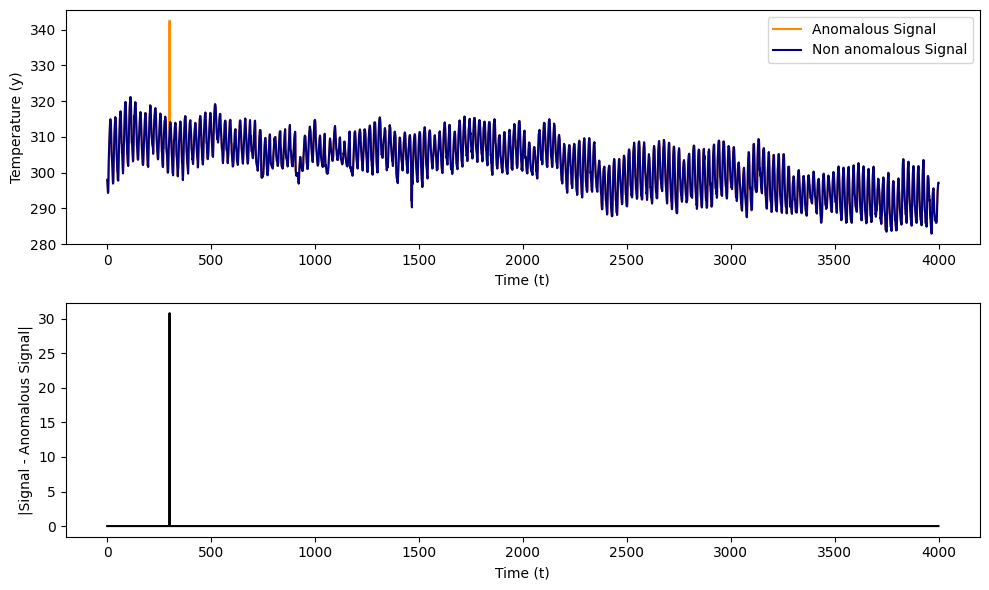

In [4]:
anomaly_data = anomaly_calibrator.inject_anomaly(location = 300, threshold = 0.1)
plot_normal_and_anomalous_signal(anomaly_data['normal_signal'], anomaly_data['anomalous_signal'])

In [20]:
# Export data for the normal and anomalous signal comparison plot
import pandas as pd

# anomaly_data contains numpy arrays, we need to get datetime from preprocessed_data
chart_data = pd.DataFrame({
    'ds': preprocessed_data['ds'].values,
    'normal_signal': anomaly_data['normal_signal'],
    'anomalous_signal': anomaly_data['anomalous_signal']
})

chart_data.to_csv('../../../posts/images/anomaly_detection_performance_evaluation/chart-1.csv', index=False)
print(f"✓ Exported {len(chart_data)} data points to chart-1.csv")
print(f"  - Anomaly location: 300")
print(f"  - Anomaly threshold: 0.1")
print(f"  - Date range: {chart_data['ds'].min()} to {chart_data['ds'].max()}")

✓ Exported 4000 data points to chart-1.csv
  - Anomaly location: 300
  - Anomaly threshold: 0.1
  - Date range: 2017-06-16 09:00:00 to 2017-11-30 00:00:00


For a fixed size of anomalies, we can generate ```num_location``` time series where the anomaly with the same fixed ```size``` is applied, for each time series, at a different location.

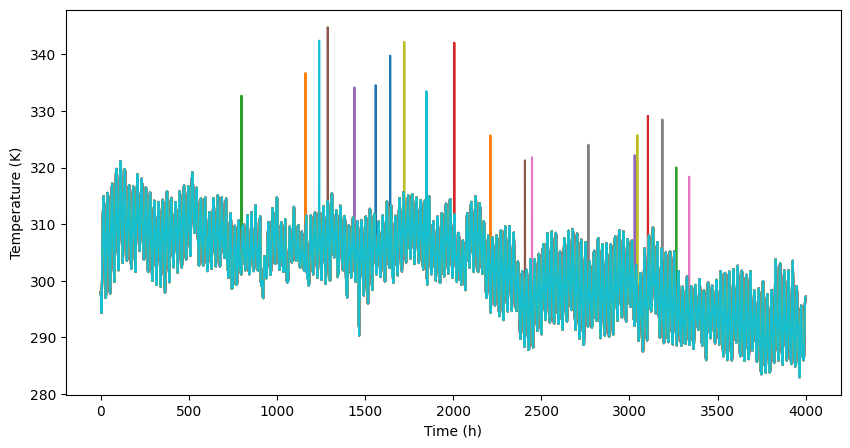

In [21]:
anomaly_calibrator.build_anomalous_dataset(num_location = 20)
anomaly_calibrator.plot_anomalous_dataset()

In [22]:
# Export data for the anomalous dataset plot
import pandas as pd

# anomaly_calibrator.anomaly_dataset contains multiple anomalous signals
# Each row is a different signal with anomaly at different location
chart_data = pd.DataFrame({
    'time_step': range(len(anomaly_calibrator.anomaly_dataset[0]))
})

# Add each anomalous signal as a separate column
for i in range(len(anomaly_calibrator.anomaly_dataset)):
    chart_data[f'signal_{i+1}'] = anomaly_calibrator.anomaly_dataset[i]

chart_data.to_csv('../../../posts/images/anomaly_detection_performance_evaluation/chart-2.csv', index=False)
print(f"✓ Exported {len(chart_data)} data points to chart-2.csv")
print(f"  - Number of anomalous signals: {len(anomaly_calibrator.anomaly_dataset)}")
print(f"  - Anomaly threshold: 0.1 (default)")
print(f"  - Each signal has anomaly at different location")

✓ Exported 4000 data points to chart-2.csv
  - Number of anomalous signals: 20
  - Anomaly threshold: 0.1 (default)
  - Each signal has anomaly at different location


### Anomaly Detection Inference
Now we have to load the Nixtla's API. In order to do that, make sure you have an API Key. Follow the instructions [here](https://www.nixtla.io/docs/getting-started-setting_up_your_api_key). Once you have your API Key, store it in your system using:
```bash
export NIXTLA_API_KEY = "your_api_key"
```
Once you followed the steps, you can easily import your Nixtla Client using:

In [23]:
anomaly_calibrator.load_nixtla_client()

Now, a very simple test that the algorithm is working can be done by running the following code:

In [24]:
location = 800
threshold = 0.05
anomaly_data = anomaly_calibrator.inject_anomaly(location = location, threshold = threshold)
test_signal = anomaly_data['anomalous_signal']
anomaly_calibrator.run_anomaly_detection(test_signal)
ds_anomaly = preprocessed_data['ds'].loc[location]
anomaly_result = anomaly_calibrator.anomaly_result
anomaly_result[anomaly_result['ds'] == ds_anomaly]

INFO:nixtla.nixtla_client:Validating inputs...


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
664,0,2017-07-19 17:00:00,320.59795,304.36893,309.00305,299.7348,True


As we can see, the model is able to correctly spot the location where we injected the anomaly. Even visually, we can see how the model is able to clearly detect the anomaly.

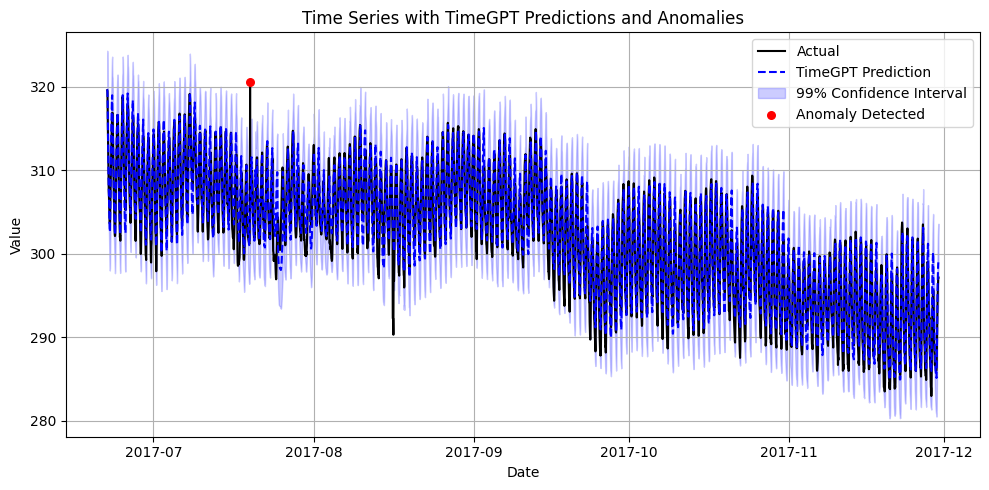

In [25]:
anomaly_calibrator.plot_anomaly_detection()

In [26]:
# Export data for the anomaly detection plot
import pandas as pd

# anomaly_calibrator.anomaly_result contains TimeGPT anomaly detection results
chart_data = anomaly_calibrator.anomaly_result[['ds', 'y', 'TimeGPT', 'TimeGPT-lo-99', 'TimeGPT-hi-99', 'anomaly']].copy()

chart_data.to_csv('../../../posts/images/anomaly_detection_performance_evaluation/chart-3.csv', index=False)
print(f"✓ Exported {len(chart_data)} data points to chart-3.csv")
print(f"  - Anomaly location: {location}")
print(f"  - Anomaly threshold: {threshold}")
print(f"  - Date range: {chart_data['ds'].min()} to {chart_data['ds'].max()}")
print(f"  - Anomalies detected: {chart_data['anomaly'].sum()}")

✓ Exported 3864 data points to chart-3.csv
  - Anomaly location: 800
  - Anomaly threshold: 0.05
  - Date range: 2017-06-22 01:00:00 to 2017-11-30 00:00:00
  - Anomalies detected: 76


### Single Calibration Run

Now, given a fixed threshold, we can see the accuracy for a given location through the ```calibration_run``` function.

In [27]:
anomaly_calibrator.calibration_run()

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


Running TimeGPT for signal number 1, with location 3228, and size 0.1
The anomaly has been detected


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


Running TimeGPT for signal number 2, with location 3253, and size 0.1
The anomaly has been detected


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


Running TimeGPT for signal number 3, with location 415, and size 0.1
The anomaly has been detected


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


Running TimeGPT for signal number 4, with location 2787, and size 0.1
The anomaly has been detected


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


Running TimeGPT for signal number 5, with location 830, and size 0.1
The anomaly has been detected
The accuracy for size 0.1 is 1.0


1.0

Amazing! So for a size of an anomaly = 0.1, TimeGPT works extremely well. The full calibration loop is based on reducing the size of anomalies, so that we can see what is the minimum detectable size of anomaly. Let's work on it. 

### Anomaly Detection Calibration Loop
The following code makes you run the calibration loop described in the **"Anomaly Detection Performance Evaluation"** chapter. 
In order for the algorithm to run we would need a desired accuracy (the minimum accuracy we want to achieve). 

In [28]:
calibration_dict = anomaly_calibrator.calibration_loop(number_of_runs = 20, desired_accuracy = 0.5)

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.1 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.09 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.08 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.07 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.06 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.05 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.04 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.03 is 1.0


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.02 is 0.9


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.01 is 0.05
The accuracy for size 0.01 is 0.05, which is smaller than the desired accuracy 0.5
The minimum detectable anomaly is 0.02


Now, as we can see, the minimum detectable anomaly is 0.02, but the accuracy there is still at 0.8. We can refine it by rerunning the calibration loop with a smaller starting size, as shown below:

In [29]:
from anomaly_calibrator import AnomalyCalibrator
anomaly_calibrator = AnomalyCalibrator(processed_data = preprocessed_data, largest_threshold_size = 0.02, step_threshold = 0.001)
anomaly_calibrator.load_nixtla_client()
refinement_calibration_dict = anomaly_calibrator.calibration_loop(number_of_runs = 20, desired_accuracy = 0.5)

/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.02 is 0.75


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.019 is 0.75


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.018 is 0.7


/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Users/khuyentran/nixtla_blog/.venv/lib/python3.11/site-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/Use

The accuracy for size 0.017 is 0.3
The accuracy for size 0.017 is 0.3, which is smaller than the desired accuracy 0.5
The minimum detectable anomaly is 0.018000000000000002


So if we are being more precise, the minimum detectable anomaly is 0.17. 